# Pre-work

## Set-up

In [1]:
!pip install tensorflow==2.0.0b1
!pip install keras

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,LSTM

seed = 7
np.random.seed(seed)

import tensorflow as tf
import pandas as pd
from pandas import Series,DataFrame

import io
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.ticker as ticker

import collections

from keras import backend as k
# from tensorflow.python.framework import ops
# ops.reset_default_graph()

from google.colab import files
import io
from io import StringIO

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn import preprocessing

     |████████████████████████████████| 87.9MB 70kB/s 
     |████████████████████████████████| 501kB 47.9MB/s 
     |████████████████████████████████| 3.1MB 42.2MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
def data_process():
  uploaded = files.upload()
  for fn in uploaded.keys():
    fn
  data = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
  data = data.iloc[:, 1:] # remove date col cuz it's meaningless here
  # data['Date_col_name'] = pd.to_datetime(data['Date_col_name'],unit='s') if here is timestamp
  data = data.astype('float64')
  data.info()
  
  return data

In [4]:
Data = data_process()

Saving DryCreek_input_add_label.csv to DryCreek_input_add_label.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6044 entries, 0 to 6043
Data columns (total 19 columns):
1-day aggregated anomaly LG Mean daily Q m^3/s    6044 non-null float64
LWR_P (precipitation)                             6044 non-null float64
LWR_T (temperature)                               6044 non-null float64
LWR_SWE (snow water equivalent)                   6044 non-null float64
LWR_Melt (snow melt)                              6044 non-null float64
LWR_ET (evapotranspiration)                       6044 non-null float64
TL_P                                              6044 non-null float64
TL_T                                              6044 non-null float64
TL_SWE                                            6044 non-null float64
TL_Melt                                           6044 non-null float64
TL_ET                                             6044 non-null float64
LWR_Soil1 (soil moisture at 10 cm

## Visualize data

what color do you want? b


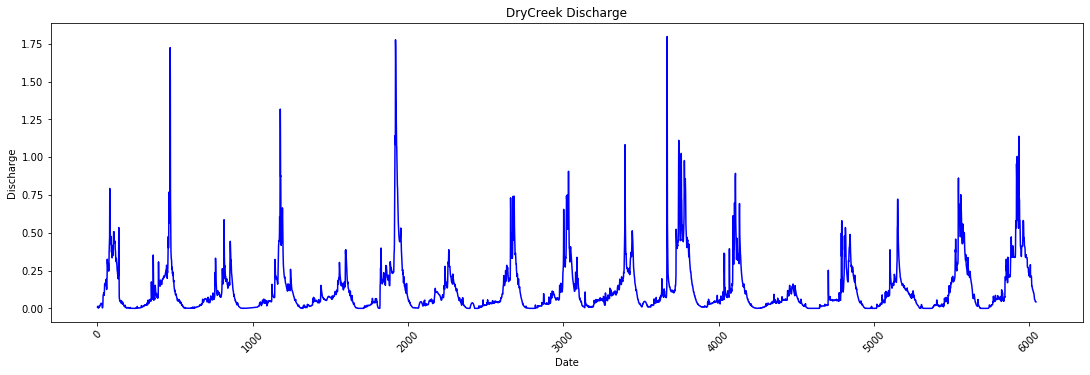

In [5]:
# plot the overall data
# Data.plot(figsize=(18,7))

# create the plot space upon which to plot the data
fig, ax= plt.subplots()

# add the x-axis and the y-axis to the plot
ax.plot(Data['1-day aggregated anomaly LG Mean daily Q m^3/s'], 
        color = input('what color do you want? '))

# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Discharge",
       title="DryCreek Discharge");

# set plot size
fig.set_size_inches(18.5, 5.5)

# Univariate LSTM Time Series Model

This model only considers previous label data

## Set-up

In [0]:
def NS(o,s): # the larger the value, the better the prediction
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    eps = 1e-5
#    return 1 - sum((np.log(s+eps)-np.log(o+eps))**2)/sum((np.log(o+eps)-np.mean(np.log(o+eps)))**2) 
    return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)

In [0]:
def data_process():
  labels = Data.iloc[:,0]
  series = np.array(labels, dtype=pd.Series)
  series = pd.to_numeric(series,errors='coerce')
  #print(pd.DataFrame(series).head())
  
  return series

In [21]:
series = data_process()

          0
0  0.007631
1  0.007957
2  0.014199
3  0.006009
4  0.004121


In [0]:
# set the training and testing set
def set_split_time(training_year, validation_year):
  split_time = 365*training_year
  end_time = 365*(training_year + validation_year)
  time = list(range(0, len(series)))
  print(split_time, end_time, time)
  
  return split_time, end_time, time

In [66]:
split_time, end_time, time = set_split_time(training_year = 9, validation_year = 3)

3285 4380 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [0]:
def data_split(series, split_time, end_time, time):
    
  x_train = series[:split_time]
  x_valid = series[split_time:end_time]
  x_test = series[end_time:]
  time_train = time[:split_time]
  time_valid = time[split_time:end_time]
  time_test = time[end_time:]
  
  print("Training, validation, and testing shape are:", x_train.shape, x_valid.shape, x_test.shape,
        "\nTraining, validation, and testing time shape are:", np.asarray(time_train).shape, np.asarray(time_valid).shape, np.asarray(time_test).shape)
  
  return x_train, x_valid, x_test, time_train, time_valid, time_test

In [68]:
x_train, x_valid, x_test, time_train, time_valid, time_test = data_split(series, split_time, end_time, time)

Training, validation, and testing shape are: (3285,) (1095,) (1664,) 
Training, validation, and testing time shape are: (3285,) (1095,) (1664,)


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [36]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(series, window_size = 30, batch_size = 32, shuffle_buffer_size = 1000)
print(train_set, x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)> (1095,)
Epoch 1/100
188/188 [==============================] - 11s 57ms/step - loss: 0.1254 - mae: 0.3125
Epoch 2/100
188/188 [==============================] - 8s 42ms/step - loss: 0.1101 - mae: 0.2875
Epoch 3/100
188/188 [==============================] - 8s 42ms/step - loss: 0.1014 - mae: 0.2632
Epoch 4/100
188/188 [==============================] - 8s 42ms/step - loss: 0.0954 - mae: 0.2545
Epoch 5/100
188/188 [==============================] - 8s 42ms/step - loss: 0.0905 - mae: 0.2483
Epoch 6/100
188/188 [==============================] - 8s 43ms/step - loss: 0.0858 - mae: 0.2396
Epoch 7/100
188/188 [==============================] - 8s 43ms/step - loss: 0.0814 - mae: 0.2296
Epoch 8/100
188/188 [==============================] - 8s 43ms/step - loss: 0.0774 - mae: 0.2208
Epoch 9/100
188/188 [==============================] - 8s 43ms/step - loss: 0.0739 - mae: 0.2135
Epoch 10/100
188/188 [==

[1e-08, 0.0001, 0, 10]

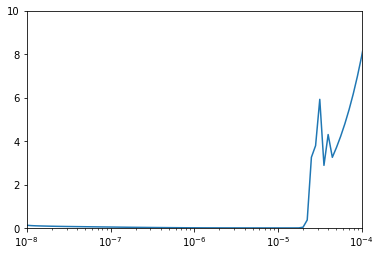

In [38]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 10])

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(series, window_size = 30, batch_size = 32, shuffle_buffer_size = 1000)
print(train_set, x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# add earlystopping tp avoid overfitting
callbacks = [
    # EarlyStoppingByLossVal(monitor='val_loss', patience=0, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_loss', patience=1, verbose=0),
    # ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=0),
]

# update the optimal learning rate, here lr is 10 to the minus 5
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500, callbacks=callbacks)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)> (1095,)
Epoch 1/500
188/188 [==============================] - 11s 57ms/step - loss: 0.0198 - mae: 0.1049
Epoch 2/500
  1/188 [..............................] - ETA: 22s - loss: 0.0099 - mae: 0.0750

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


188/188 [==============================] - 8s 42ms/step - loss: 0.0084 - mae: 0.0740
Epoch 3/500
188/188 [==============================] - 8s 42ms/step - loss: 0.0072 - mae: 0.0683
Epoch 4/500
188/188 [==============================] - 8s 42ms/step - loss: 0.0068 - mae: 0.0666
Epoch 5/500
188/188 [==============================] - 8s 42ms/step - loss: 0.0065 - mae: 0.0641
Epoch 6/500
188/188 [==============================] - 8s 43ms/step - loss: 0.0060 - mae: 0.0594
Epoch 7/500
188/188 [==============================] - 8s 42ms/step - loss: 0.0056 - mae: 0.0546
Epoch 8/500
188/188 [==============================] - 8s 42ms/step - loss: 0.0054 - mae: 0.0536
Epoch 9/500
188/188 [==============================] - 8s 43ms/step - loss: 0.0053 - mae: 0.0528
Epoch 10/500
188/188 [==============================] - 8s 42ms/step - loss: 0.0051 - mae: 0.0515
Epoch 11/500
188/188 [==============================] - 8s 43ms/step - loss: 0.0049 - mae: 0.0503
Epoch 12/500
188/188 [==================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size = 30)

### Note (for myself)

In [0]:
window_size = 30

In [76]:
end_time - split_time

1095

In [81]:
len(rnn_forecast)

6015

In [93]:
len(rnn_forecast) + window_size

6045

In [94]:
len(rnn_forecast[split_time - window_size:end_time - window_size])

1095

In [102]:
len(rnn_forecast[end_time - window_size +1:, -1, 0])

1664

In [0]:
x_train, x_valid, x_test, time_train, time_valid, time_test = data_split(series, split_time, end_time, time)

Training, validation, and testing shape are: (3285,) (1095,) (1664,) 
Training, validation, and testing time shape are: (3285,) (1095,) (1664,)


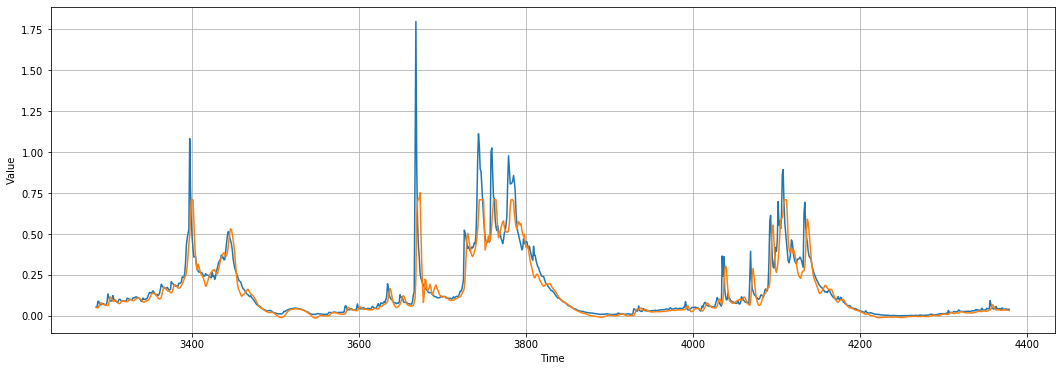

In [98]:
plt.figure(figsize=(18, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast[split_time - window_size:end_time - window_size:,-1,0])

### Prediction Result

In [0]:
# validation prediction
def val_pred(plot):
  
  # plot prediction
  if plot == True:
    plt.figure(figsize=(18, 6))
    plot_series(time_valid, x_valid)
    plot_series(time_valid, rnn_forecast[split_time - window_size:end_time - window_size:,-1,0])
    plt.title("Validation Prediction")
  
  mae = mean_absolute_error(x_valid, rnn_forecast[split_time - window_size:end_time - window_size:,-1,0])
  mse = mean_squared_error(x_valid, rnn_forecast[split_time - window_size:end_time - window_size:,-1,0])
  ns = NS(x_valid, rnn_forecast[split_time - window_size:end_time - window_size:,-1,0])
  
  print("MAE:", mae, "\nMSE:",mse, "\nNS:",ns)
  
  return mae, mse, ns

MAE: 0.03616450455530826 
MSE: 0.008245650193534257 
NS: 0.7803534859923167


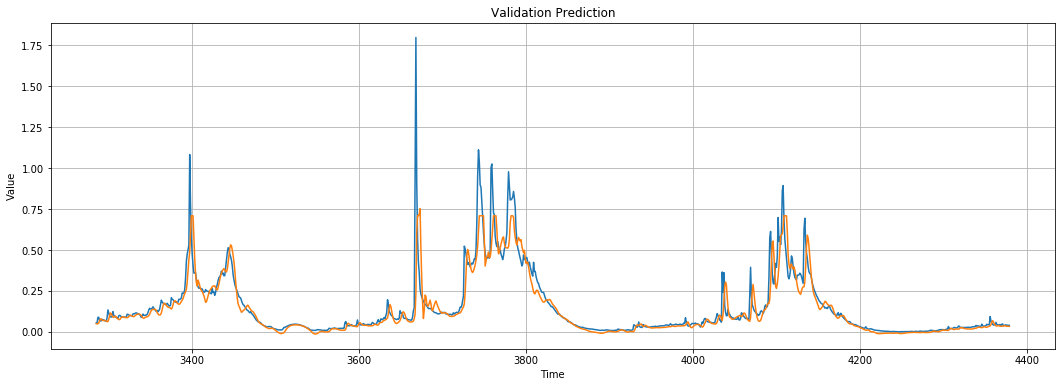

In [112]:
val_mae, val_mse, val_ns = val_pred(plot = True)

In [0]:
# test prediction
def test_pred(plot):
  
  # plot prediction
  if plot == True:
    plt.figure(figsize=(18, 6))
    plot_series(time_test, x_test)
    plot_series(time_test, rnn_forecast[end_time - window_size +1:, -1, 0])
    plt.title("Testing Prediction")
  
  mae = mean_absolute_error(x_test, rnn_forecast[end_time - window_size +1:, -1, 0])
  mse = mean_squared_error(x_test, rnn_forecast[end_time - window_size +1:, -1, 0])
  ns = NS(x_test, rnn_forecast[end_time - window_size +1:, -1, 0])
  
  print("MAE:", mae, "\nMSE:",mse, "\nNS:",ns)
  
  return mae, mse, ns

MAE: 0.02200207682481642 
MSE: 0.0019007744740934518 
NS: 0.9283553462156048


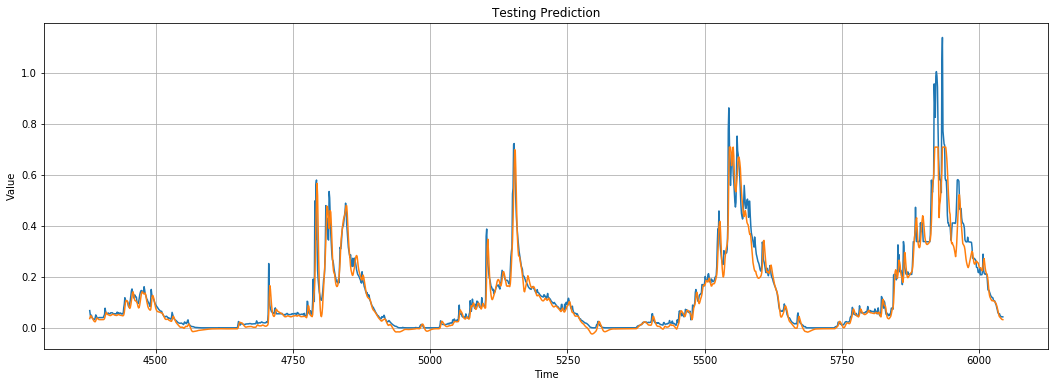

In [115]:
test_mae, test_mse, test_ns = test_pred(plot = True)

In [110]:
print(rnn_forecast)

[[[0.11406681]
  [0.06918395]
  [0.02137655]
  ...
  [0.03116839]
  [0.02946071]
  [0.02627228]]

 [[0.11412878]
  [0.07055774]
  [0.02241251]
  ...
  [0.0293111 ]
  [0.02604928]
  [0.02050754]]

 [[0.11531603]
  [0.07168888]
  [0.02233763]
  ...
  [0.02591764]
  [0.02030106]
  [0.01158537]]

 ...

 [[0.14829686]
  [0.17208108]
  [0.20697546]
  ...
  [0.04276694]
  [0.03759079]
  [0.03375202]]

 [[0.14799973]
  [0.17128675]
  [0.2022456 ]
  ...
  [0.03911266]
  [0.03532279]
  [0.03261375]]

 [[0.14798841]
  [0.16753538]
  [0.19019899]
  ...
  [0.03638496]
  [0.03377013]
  [0.03212225]]]
